In [1]:
import pandas as pd
import scanpy as sc
import decoupler as dc
import seaborn as sns
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['pdf.fonttype'] = 42

import sys
scr_path = '/nfs/team292/hm11/endo_GLND/starsolo/GLND/Thyroid/snippets'
sys.path.append(scr_path)
import singleCellFun as sf

import warnings
warnings.filterwarnings('ignore')

/home/jovyan/my-conda-envs/sc_Harm/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
# load single cell data to import metadata
adata = sc.read('../../Thyrocytes/workingObj/adata_thy_ALL_harm_noStressEmb.h5ad')
# add age groups
labels = ['9-10','11-13','14-20']
adata.obs['age_group'] = pd.cut(adata.obs['pcw'].astype(int), bins=[0, 10, 13, 20], include_lowest=True, labels=labels).rename('age_group')
# add celltype annotations
annot = pd.read_csv('../../Thyrocytes/workingObj/adata_thy_ALL_harm_annotations.csv', index_col=0)
adata.obs = pd.concat([adata.obs.loc[:,~adata.obs.columns.isin(annot.columns)], annot], axis=1)
sf.summaryTable(adata,['sample','donor','pcw','gender','karyotype','age_group'])

[INFO] - total cells: 49853


,age_group,donor,sample,karyotype,gender,pcw,cells
0,11-13,Hrv188,HCA_GLNDrna13255575,2n,male,11,5354
1,11-13,Hrv195,HCA_GLNDrna13255574,2n,male,11,3118
2,11-13,Hrv256,HCA_GLNDrna14495896,T21,male,11,2812
3,11-13,Hrv257,HCA_GLNDrna14495897,T21,male,11,1253
4,11-13,Hrv116,HCA_GLNDrna11814746,2n,male,12,2599
5,11-13,Hrv197,HCA_GLNDrna13255576,2n,female,12,2478
6,11-13,Hrv218,HCA_GLNDrna13460410,2n,male,12,2229
7,11-13,Hrv265,HCA_GLNDrna14662854,T21,female,12,1766
8,11-13,Hrv266,HCA_GLNDrna14704272,T21,male,12,797
9,14-20,Hrv194,HCA_GLNDrna13255573,2n,female,14,5520


In [3]:
adata.uns['celltype_colors'] = sf.updateColors(adata, 'celltype', sf.readExcelColors('celltype'))


celltype not found in adata.uns. Generating adata.uns...
[INFO] adding index ['imm_MEMP', 'smc_Cycling', 'end_Capillary', 'imm_B_cells', 'epi_SCGB3A2', 'end_Venous', 'mes_SCN7A', 'epi_HLA-B', 'imm_Cycling_T_cells', 'epi_COL14A1', 'smc_Pericytes', 'mes_Chondrocytes', 'myo_Cycling_Myogenic_Progenitor', 'myo_Differentiated_Myoblasts', 'imm_NK_cells', 'smc_GPC3', 'myo_Myogenic_Progenitor', 'end_Cycling', 'pat_Cycling_Parathyrocytes', 'mes_CCL19', 'imm_Pro-B_cells', 'smc_SMCs', 'mes_CYGB', 'neu_Cycling_Myelinating_Glial_cells', 'imm_Mast_cells', 'end_Lymphatic', 'mes_KCNB2', 'paf_C_cells', 'myo_Myoblast', 'imm_Macrophages', 'RBC_lowQC', 'imm_T_cells', 'imm_ILCs', 'neu_Myelinating_Glial_cells', 'mes_ACKR3', 'mes_LTBP1', 'neu_ENS_Neurons', 'epi_Cycling', 'imm_DC_prec', 'imm_Monocytes', 'mes_IGF1R', 'pat_Parathyrocytes', 'end_Arterial', 'imm_DN/DP_T_cells', 'imm_Cycling_NK', 'imm_DC2', 'mes_Cycling'] to color list...


In [4]:
# read colors
col_dict = pd.read_csv('../../../age_group_colors.csv').to_dict()['colors']
adata.uns['age_group_colors'] = sf.updateColors(adata, 'age_group', col_dict)
# read colors
col_dict = pd.read_csv('../../../karyotype_colors.csv').to_dict()['colors']
adata.uns['karyotype_colors'] = sf.updateColors(adata, 'karyotype', col_dict)

age_group not found in adata.uns. Generating adata.uns...
[INFO] adding index [0, 1, 2] to color list...
[INFO] adding index [0, 1] to color list...


In [5]:
metadata = adata.obs[['sample','donor','pcw','gender','karyotype']]
metadata = metadata.reset_index(drop=True).drop_duplicates().set_index('donor')
# add age groups
labels = ['9-10','11-13','14-20']
age_group = pd.cut(metadata['pcw'].astype(int), bins=[0, 10, 13, 20], include_lowest=True, labels=labels).rename('age_group')
metadata = pd.concat([metadata, age_group], axis=1)

In [6]:
# load
collapsed = pd.read_csv('../data/geneENS_table.csv')
collapsed.head()

,gene,ENS
0,A1BG,ENSG00000121410
1,A1BG-AS1,ENSG00000268895
2,A1CF,ENSG00000148584
3,A2M,ENSG00000175899
4,A2M-AS1,ENSG00000245105


In [8]:
def readBulk(pTable, collapsed, metadata, obs_colname, obs_value):
    df = pd.read_csv(pTable, index_col=0)
    pdata = sc.AnnData(df.T)
    pdata.obs[obs_colname] = obs_value
    pdata.obs['donor'] = pdata.obs.index
    pdata.obs = pd.merge(pdata.obs, metadata, on='donor').set_index('sample')
    
    pdata.layers['counts'] = pdata.X.copy()
    sc.pp.normalize_total(pdata, target_sum=1e6)
    sc.pp.log1p(pdata)
    sc.pp.scale(pdata, max_value=10)
    return(pdata)

In [11]:
# read fTFC1 
pTable_fTFC1 = '/lustre/scratch126/cellgen/team292/mt22/ThyroidDev/pb_T21vs2n/fTFC1.csv'
pTable_fTFC2 = '/lustre/scratch126/cellgen/team292/mt22/ThyroidDev/pb_T21vs2n/fTFC2.csv'
pdata_fTFC1 = readBulk(pTable_fTFC1, collapsed, metadata, obs_colname='celltype', obs_value='fTFC1')
pdata_fTFC2 = readBulk(pTable_fTFC2, collapsed, metadata, obs_colname='celltype', obs_value='fTFC2')

# concat the two pdatas
pdata = anndata.concat([pdata_fTFC1, pdata_fTFC2], join='outer')
pdata.var['gene'] = pdata.var.index.map(dict(collapsed[['ENS','gene']].values))
pdata.var = pdata.var.reset_index(names='ENS').set_index('gene')
pdata.var
pdata

AnnData object with n_obs × n_vars = 42 × 16459
    obs: 'celltype', 'donor', 'pcw', 'gender', 'karyotype', 'age_group'
    var: 'ENS'
    layers: 'counts'

In [12]:
pdata.obs['join'] = pdata.obs['karyotype'].astype(str)+str('_')+pdata.obs['celltype'].astype(str)

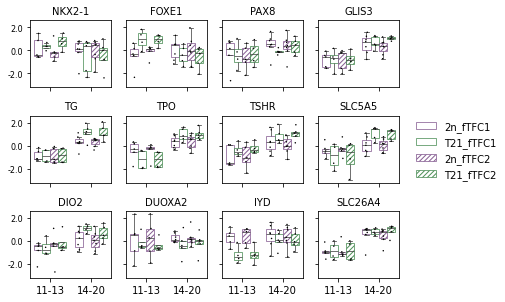

In [348]:
gg = ['NKX2-1','FOXE1','PAX8','GLIS3','TG','TPO','TSHR','SLC5A5','DIO2','DUOXA2','IYD','SLC26A4']
palette_cols = {'2n_fTFC2':'#8D579D', '2n_fTFC1':'#8D579D','T21_fTFC1':'#449B52', 'T21_fTFC2':'#449B52'}

mcols ='k'
ncols = 4
df2plot = pd.concat([pdata.to_df()[gg],pdata.obs], axis=1)
df2plot = df2plot.melt(id_vars=pdata.obs, var_name='gene')
df2plot['age_group'] = df2plot['age_group'].astype(str) #remove unused cats
g = sns.catplot(df2plot, x='age_group', y='value', hue='join', col='gene', col_wrap=ncols, 
                showfliers=False, height=1.5, aspect=1, kind='box', palette=palette_cols,
                facet_kws={'despine':False}, linewidth=0.75, whiskerprops={'linewidth':0.75})

g.map_dataframe(sns.stripplot, x='age_group', y='value', hue='join', dodge=True, palette=[mcols,mcols,mcols,mcols],
                legend=True, s=1.5)
for ax, title in zip(g.axes.flatten(),gg):
    ax.set_title(title, fontdict={'fontsize':10})
    ax.set_ylabel('')
    ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize':8})
    ax.set_xlabel('')

hatches = ['', '', '/////', '/////']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    h = [item for item in hatches for _ in range((len(patches) // len(hatches)))]    
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        fc = patch.get_facecolor()
        patch.set_edgecolor(fc)
        patch.set_facecolor('none')
        
for lp, hatch in zip(g.legend.get_patches(), hatches):
    lp.set_hatch(hatch)
    fc = lp.get_facecolor()
    lp.set_edgecolor(fc)
    lp.set_facecolor('none')
g.legend.set_title('')
plt.savefig('figures/T21_TH_core_genes_box.pdf', dpi=300)

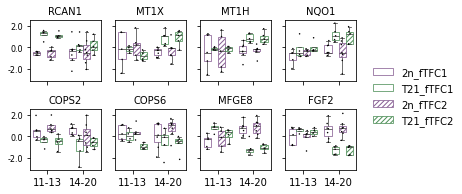

In [26]:
gg = ['RCAN1','MT1X','MT1H','NQO1',
      'COPS2','COPS6','MFGE8','FGF2'] #COL18A1']
palette_cols = {'2n_fTFC2':'#8D579D', '2n_fTFC1':'#8D579D','T21_fTFC1':'#449B52', 'T21_fTFC2':'#449B52'}

mcols ='k'
ncols = 4
df2plot = pd.concat([pdata.to_df()[gg],pdata.obs], axis=1)
df2plot = df2plot.melt(id_vars=pdata.obs, var_name='gene')
df2plot['age_group'] = df2plot['age_group'].astype(str) #remove unused cats
g = sns.catplot(df2plot, x='age_group', y='value', hue='join', col='gene', col_wrap=ncols, 
                showfliers=False, height=1.5, aspect=0.9, kind='box', palette=palette_cols,
                facet_kws={'despine':False}, linewidth=0.75, whiskerprops={'linewidth':0.75})

g.map_dataframe(sns.stripplot, x='age_group', y='value', hue='join', dodge=True, palette=[mcols,mcols,mcols,mcols],
                legend=True, s=1.5)
for ax, title in zip(g.axes.flatten(),gg):
    ax.set_title(title, fontdict={'fontsize':10})
    ax.set_ylabel('')
    ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize':8})
    ax.set_xlabel('')

hatches = ['', '', '/////', '/////']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    h = [item for item in hatches for _ in range((len(patches) // len(hatches)))]    
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        fc = patch.get_facecolor()
        patch.set_edgecolor(fc)
        patch.set_facecolor('none')
        
for lp, hatch in zip(g.legend.get_patches(), hatches):
    lp.set_hatch(hatch)
    fc = lp.get_facecolor()
    lp.set_edgecolor(fc)
    lp.set_facecolor('none')
g.legend.set_title('')
plt.savefig('figures/selected_genes_T21_TH_core_genes_box.pdf', dpi=300)